In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

sys.path.append(os.path.abspath('src'))

### <span style="color: lightskyblue;"> Carga de datos </span>

In [3]:
import pandas as pd
from utils import clean_and_load
from tqdm import tqdm

archivos = [
    ('data/raw/trips_2020.csv', ['Unnamed: 0'], None),
    ('data/raw/trips_2021.csv', ['Unnamed: 0', 'genero'], None),
    ('data/raw/trips_2022.csv', ['Unnamed: 0', 'X'], {'Género': 'genero'}),
    ('data/raw/trips_2023.csv', ['Unnamed: 0'], None),
    ('data/raw/trips_2024.csv', None, None),
]

dfs = []

for path, drop_cols, rename_cols in tqdm(archivos, desc="Procesando archivos"):
    df = clean_and_load(path, drop_cols=drop_cols, rename_cols=rename_cols)
    dfs.append(df)

trips_2020, trips_2021, trips_2022, trips_2023, trips_2024 = dfs


Procesando archivos: 100%|██████████| 5/5 [05:47<00:00, 69.45s/it]


In [52]:
# Imprimir la cantidad de viajes por año
print("Cantidad de viajes por año:")
print(f"2020: {len(trips_2020)}")
print(f"2021: {len(trips_2021)}")
print(f"2022: {len(trips_2022)}")
print(f"2023: {len(trips_2023)}")
print(f"2024: {len(trips_2024)}")


Cantidad de viajes por año:
2020: 2415597
2021: 2860091
2022: 2922805
2023: 2622331
2024: 3559284


In [4]:
trips_2024_filtered = trips_2024[trips_2024['fecha_origen_recorrido'].dt.month <= 8]
trips_2024_test = trips_2024[trips_2024['fecha_origen_recorrido'].dt.month >= 9]

trips = pd.concat([trips_2020, trips_2021, trips_2022, trips_2023, trips_2024_filtered], ignore_index=True)

trips.to_csv('data/processed/trips.csv', index=False)
trips_2024_test.to_csv('data/processed/trips_test.csv', index=False)


In [ ]:
trips = pd.concat([trips_2020, trips_2021, trips_2022, trips_2023, trips_2024_filtered], ignore_index=True)
print("Cantidad de viajes en el dataset final:")
print(f"Total: {len(trips)}")


Cantidad de viajes en el dataset final:
Total: 12976469


### <span style="color: lightskyblue;"> Exploración de datos </span>

In [55]:
# Imprimir la cantidad de viajes
print(f"Viajes totales: {len(trips)}")

Viajes totales: 12976469


In [56]:
# Imprimir la cantidad de estaciones 
print(f"Cantidad de estaciones origen: {trips['id_estacion_origen'].nunique()} \nCantidad de estaciones destino: {trips['id_estacion_destino'].nunique()}")

Cantidad de estaciones origen: 858 
Cantidad de estaciones destino: 860


In [57]:
# imprimir la vantidad de viajes por año 
print("Cantidad de viajes por año:")
print(trips['fecha_origen_recorrido'].dt.year.value_counts().sort_index())


Cantidad de viajes por año:
fecha_origen_recorrido
2020    2415597
2021    2860091
2022    2922805
2023    2622331
2024    2155645
Name: count, dtype: int64


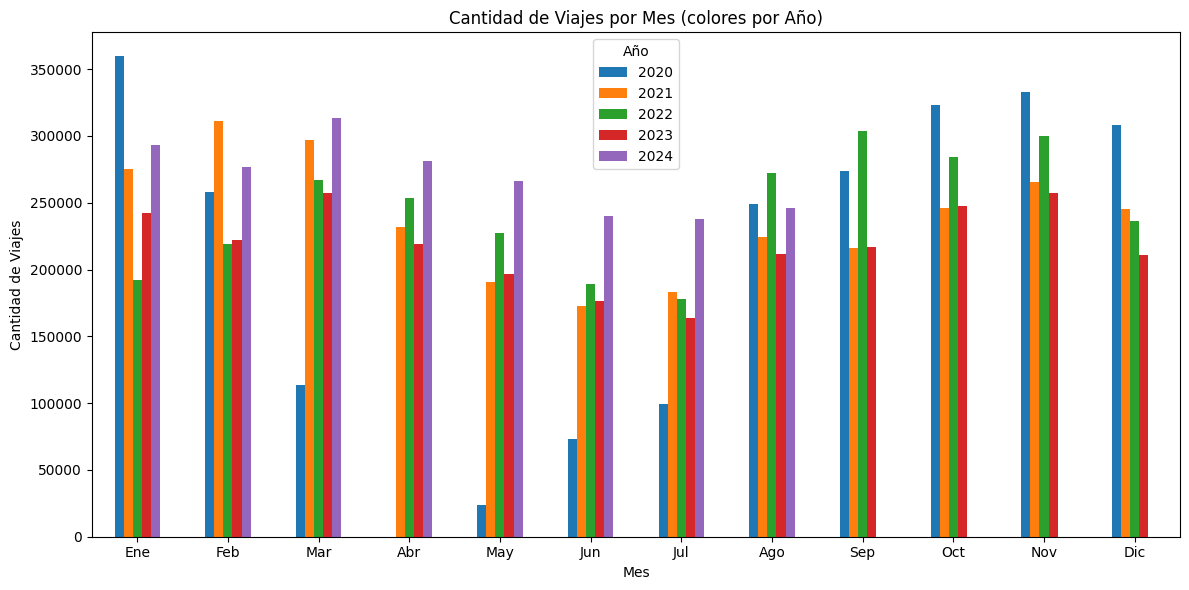

In [59]:
import matplotlib.pyplot as plt

# Solo extraemos las columnas necesarias para reducir memoria
fechas = trips['fecha_origen_recorrido']

# Extraer año y mes de forma eficiente y en paralelo
meses = fechas.dt.month.to_numpy()
anios = fechas.dt.year.to_numpy()

# Crear un nuevo DataFrame mínimo con solo lo necesario
import pandas as pd
viajes_mes_anio = pd.DataFrame({'anio': anios, 'mes': meses})

# Agrupar y pivotear
pivot = viajes_mes_anio.value_counts().reset_index(name='cantidad')
pivot_df = pivot.pivot(index='mes', columns='anio', values='cantidad').fillna(0).astype(int)

# Graficar
pivot_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Mes')
plt.ylabel('Cantidad de Viajes')
plt.title('Cantidad de Viajes por Mes (colores por Año)')
plt.xticks(ticks=range(0, 12), labels=[
    'Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'
], rotation=0)
plt.legend(title='Año')
plt.tight_layout()
plt.show()


Quizas incluir los datos de 2020 puede ser un outlier (son valores raros)

In [60]:
print(trips['duracion_recorrido'].describe())
print(trips['duracion_recorrido'].isna().sum())
print((trips['duracion_recorrido'] <= 0).sum())


count    1.297647e+07
mean     1.385654e+03
std      1.443910e+04
min      0.000000e+00
25%      5.960000e+02
50%      9.810000e+02
75%      1.550000e+03
max      1.943331e+07
Name: duracion_recorrido, dtype: float64
0
21281


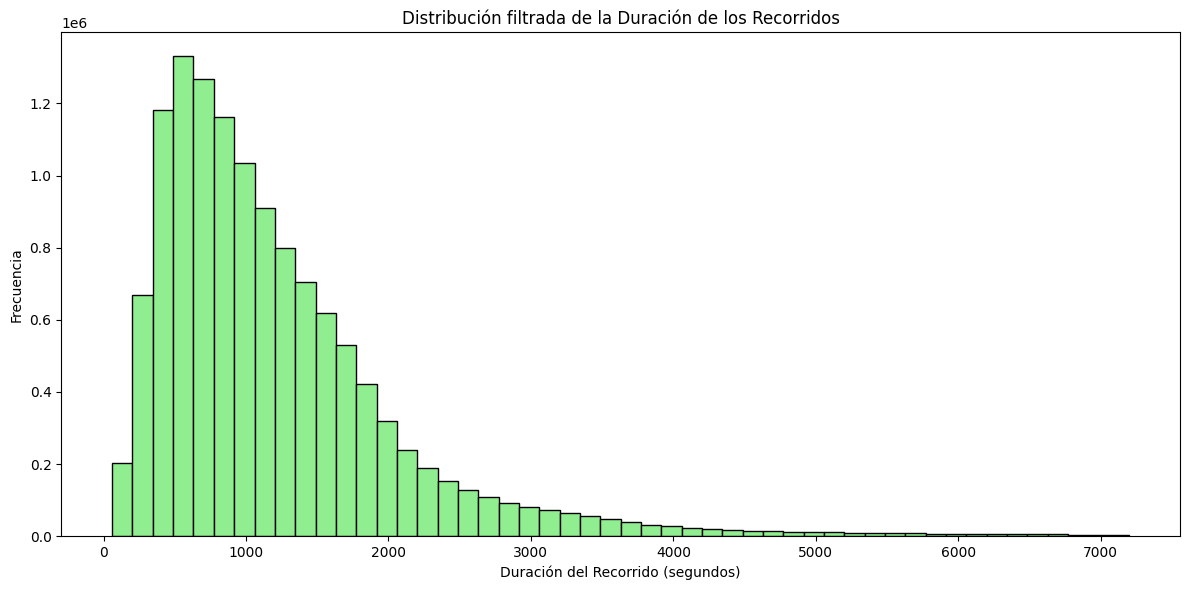

In [61]:
# Filtrar recorridos entre 1 minuto y 1 hora
duraciones_filtradas = trips[(trips['duracion_recorrido'] >= 60) & 
                             (trips['duracion_recorrido'] <= 7200)]['duracion_recorrido']

plt.figure(figsize=(12, 6))
plt.hist(duraciones_filtradas, bins=50, color='lightgreen', edgecolor='black')
plt.xlabel('Duración del Recorrido (segundos)')
plt.ylabel('Frecuencia')
plt.title('Distribución filtrada de la Duración de los Recorridos')
plt.tight_layout()
plt.show()

La duración del viaje se podría modelar como una normal (ver arriba mean, std)

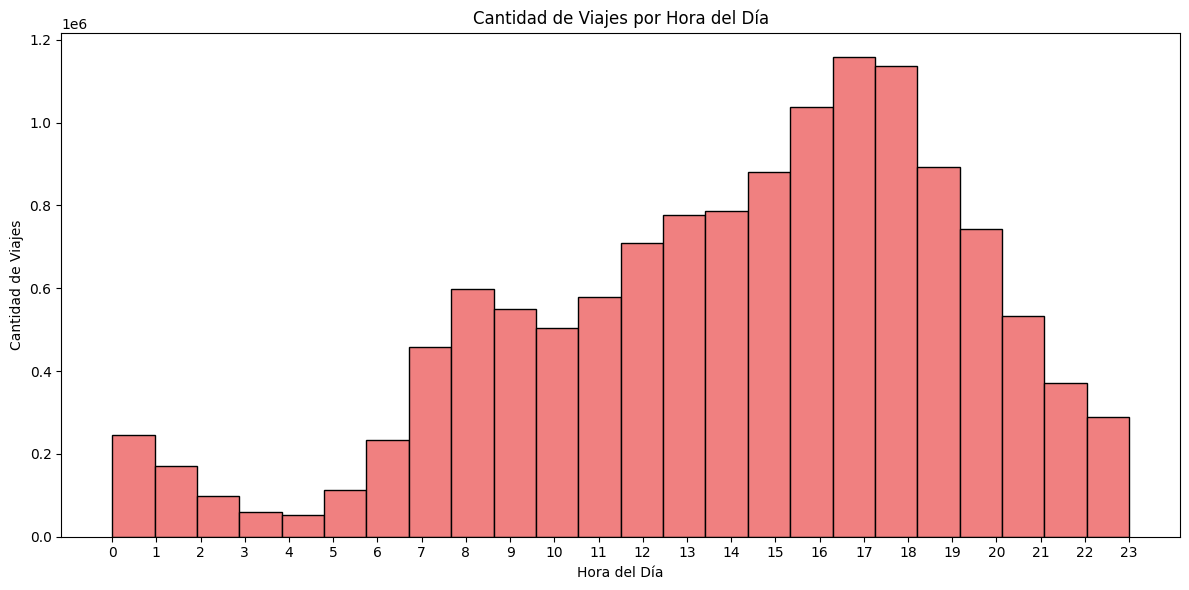

In [62]:
# Histograma de los horarios en que se realizan los viajes
trips['hora_origen_recorrido'] = trips['fecha_origen_recorrido'].dt.hour
plt.figure(figsize=(12, 6))
plt.hist(trips['hora_origen_recorrido'], bins=24, color='lightcoral', edgecolor='black')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Viajes')
plt.title('Cantidad de Viajes por Hora del Día')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

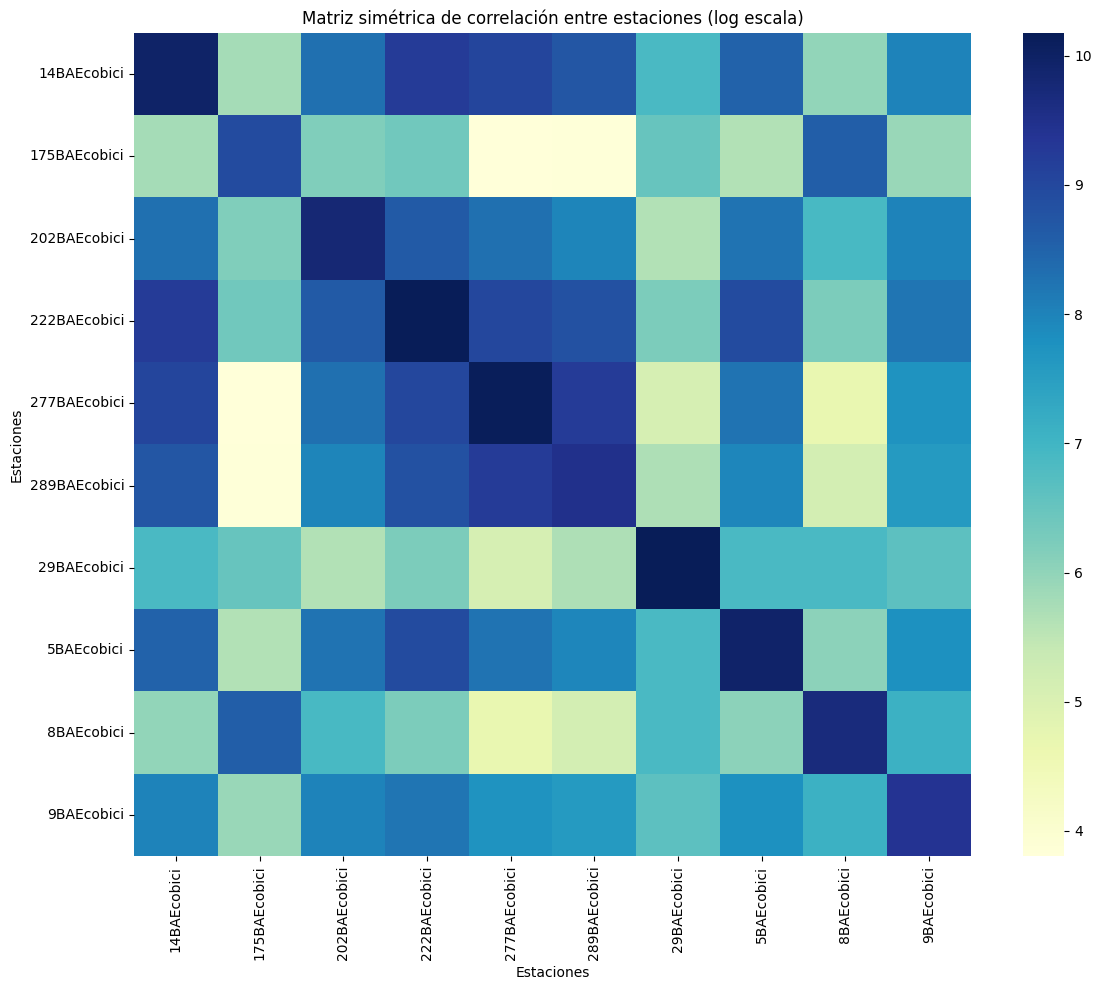

In [46]:
import numpy as np
import seaborn as sns

# Eliminar filas con NaN en las columnas relevantes
trips = trips.dropna(subset=['id_estacion_origen', 'id_estacion_destino'])

# Paso 1 (optimizado): crear columnas 'station1' y 'station2' de forma vectorizada
trips['station1'] = np.minimum(trips['id_estacion_origen'], trips['id_estacion_destino'])
trips['station2'] = np.maximum(trips['id_estacion_origen'], trips['id_estacion_destino'])

# Paso 2: filtrar top estaciones (lo movemos antes de agrupar)
top_stations = pd.concat([
    trips['station1'],
    trips['station2']
]).value_counts().nlargest(100).index

trips = trips[trips['station1'].isin(top_stations) & trips['station2'].isin(top_stations)]

# Paso 3: contar ocurrencias de cada par (sin dirección)
pair_counts = trips.groupby(['station1', 'station2']).size().reset_index(name='count')

# Paso 4: construir matriz
correlation_matrix = pair_counts.pivot(index='station1', columns='station2', values='count').fillna(0)

# Paso 5: simetrizar matriz (como estación1 ≤ estación2, solo rellenamos abajo)
correlation_matrix = correlation_matrix + correlation_matrix.T.fillna(0)

# Paso 6: heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(np.log1p(correlation_matrix), cmap='YlGnBu')
plt.title('Matriz simétrica de correlación entre estaciones (log escala)')
plt.xlabel('Estaciones')
plt.ylabel('Estaciones')
plt.tight_layout()
plt.show()


In [5]:
# Mapa de calor: estacion origen vs estacion destino
def heatmap_data(df):
    heatmap_df = df.groupby(['id_estacion_origen', 'id_estacion_destino']).size().reset_index(name='count')
    heatmap_df = heatmap_df.pivot(index='id_estacion_origen', columns='id_estacion_destino', values='count').fillna(0)
    return heatmap_df

heatmap_df = heatmap_data(trips)

In [8]:
print(heatmap_df.describe())
print("Valores únicos (origen):", len(heatmap_df.index))
print("Valores únicos (destino):", len(heatmap_df.columns))
print("Cantidad de ceros:", (heatmap_df == 0).sum().sum())

id_estacion_destino         101  101BAEcobici         102  102BAEcobici  \
count                858.000000    858.000000  858.000000    858.000000   
mean                   5.606061     41.523310    5.494172     13.236597   
std                   26.231597    144.105222   24.827020     41.283902   
min                    0.000000      0.000000    0.000000      0.000000   
25%                    0.000000      0.000000    0.000000      0.000000   
50%                    0.000000      0.000000    0.000000      0.000000   
75%                    1.000000     15.000000    2.000000      7.000000   
max                  531.000000   2189.000000  571.000000    460.000000   

id_estacion_destino         104  104BAEcobici  105BAEcobici  106BAEcobici  \
count                858.000000    858.000000    858.000000    858.000000   
mean                   8.294872     45.354312      3.526807      1.644522   
std                   39.175850    201.674433     16.167006      5.502368   
min             

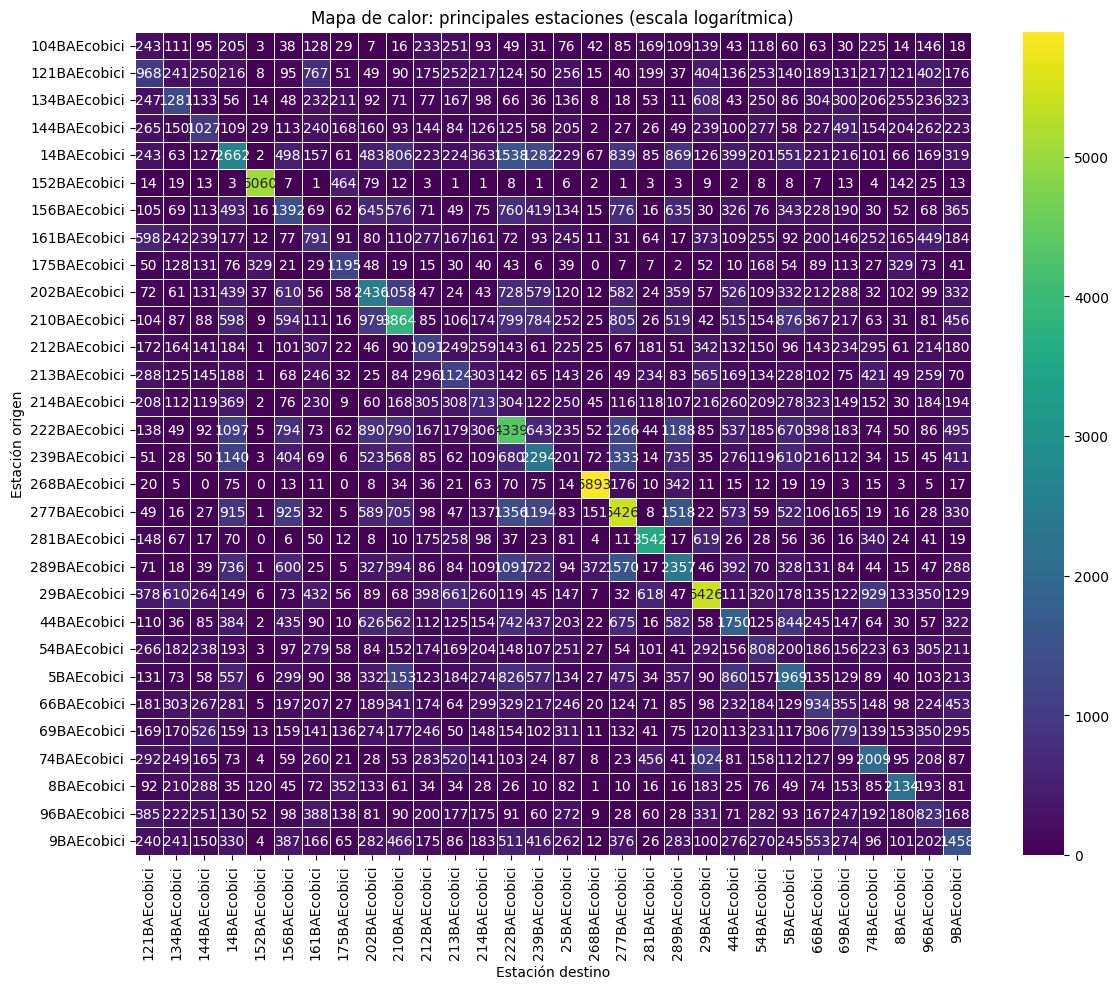

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las 30 estaciones con más salidas y llegadas
top_origenes = df['id_estacion_origen'].value_counts().nlargest(30).index
top_destinos = df['id_estacion_destino'].value_counts().nlargest(30).index

df_filtrado = df[df['id_estacion_origen'].isin(top_origenes) & df['id_estacion_destino'].isin(top_destinos)]

# Generar nuevo heatmap reducido
heatmap_df_top = heatmap_data(df_filtrado)

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_df_top, cmap='viridis', linewidths=0.5, annot=True, fmt=".0f")
plt.title("Mapa de calor: principales estaciones (escala logarítmica)")
plt.xlabel("Estación destino")
plt.ylabel("Estación origen")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### <span style="color: lightskyblue;"> Modelos Baseline </span>

In [64]:
### USO SOLO LOS DATOS DE 2020 PARA BASELINE 

df = trips_2020.copy()
df.to_parquet('data/processed/trips_baseline.parquet')

T = 15
df['ventana_origen'] = df['fecha_origen_recorrido'].dt.floor('15T')
df['ventana_destino'] = df['fecha_destino_recorrido'].dt.floor('15T')

arribos = df.groupby(['ventana_destino', 'id_estacion_destino']).size().reset_index(name='arribos')
salidas = df.groupby(['ventana_origen', 'id_estacion_origen']).size().reset_index(name='salidas')

df['hora'] = df['ventana_origen'].dt.hour
df['dia_semana'] = df['ventana_origen'].dt.dayofweek

media_horaria = arribos.copy()
media_horaria['hora'] = media_horaria['ventana_destino'].dt.hour
media_por_estacion_hora = media_horaria.groupby(['id_estacion_destino', 'hora'])['arribos'].mean().reset_index()

# from sklearn.metrics import mean_absolute_error, mse

# mae = mean_absolute_error(y_true, y_pred)
# rmse = mse(y_true, y_pred, squared=False)

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.